In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # 데이터 시각화
import seaborn as sns
import missingno as msno
import os
import re
import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2

%matplotlib inline
plt.rcParams["figure.figsize"] = (13,10)

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import keras
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
seed = 777

Using TensorFlow backend.


In [3]:
## 실제 데이터 로드
realData1 = "Train/30.csv"
realData2 = "Test/1154.csv"
realData3 = "Test/1168.csv"
realData4 = "additinal_data/additinal_data1"
realData5 = "additinal_data/additinal_data2"

In [4]:
## 데이터 Path
train_folder = 'train/'
test_folder = 'test/'
train_label_path = 'train_label.csv'
train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

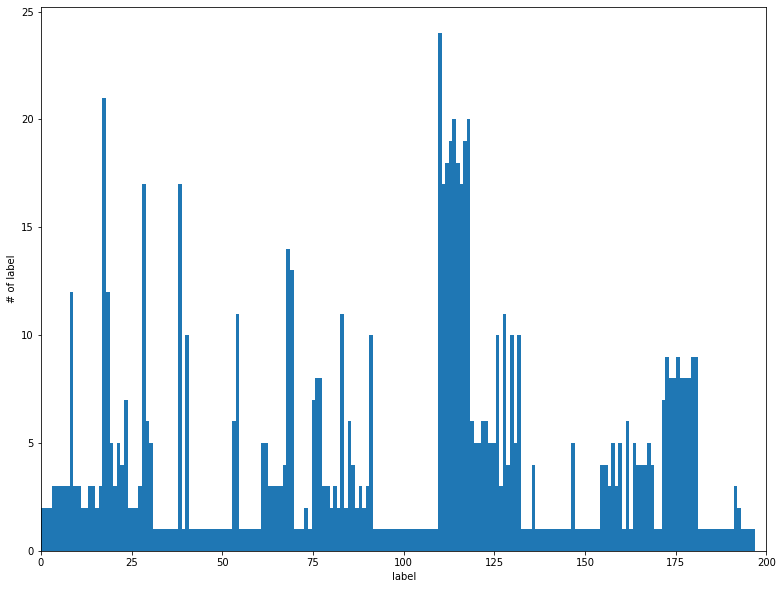

총 데이터의 개수 :  828


In [5]:
# Dacon 토론에서 공개된 Label당 Imbalance Data 분포도
train_l = pd.read_csv("train_label.csv")
plt.hist(train_l['label'], bins=len(train_l['label'].unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()
print("총 데이터의 개수 : ",len(train_l['label']))
list = []
for i in range(len(train_l['label'].unique())):
    list.append(len(train_l[:][train_l['label']==i]))

# Data Preprocessing 

In [57]:
# 모든 csv 파일의 상태_B로 변화는 시점이 같다라고 가정, 10초
# 하지만, 개별 csv파일의 상태_B로 변화는 시점은 상이할 수 있음, 60개의 row만 보기, 즉 10~60초의 시간만 학습
# Dacon baseline으로 지정해주는 데이터 로드 함수
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

In [6]:
# Dacon에서 제공해주는 함수를 이용한 데이터 Merge와 csv 저장 및 불러오기
#train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=60)
#train.to_csv("base_train.csv")
train = pd.read_csv("base_train.csv", index_col='Unnamed: 0')

#test = data_loader_all_v2(data_loader_v2, test_list, folder=test_folder, train_label=None, event_time=10, nrows=60)
#test.to_csv("base_test.csv")
test = pd.read_csv("base_test.csv", index_col='Unnamed: 0')

In [7]:
# Data에 대해 y = label 과 trainData 분리
train_c = train.copy()
train_label = train_c['label']
train_data = train_c.drop(['label'], axis=1)

In [8]:
# Data에 대해 train과 검증 데이터 분리
X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=seed)
print(X_train,X_val,Y_train,Y_val)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

         V0000     V0001     V0002     V0003     V0004       V0005  \
666  30.460902  8.696729  8.678150  8.707048  8.743941  187.271493   
675  30.467751  8.634908  8.721089  8.677828  8.720551  208.165981   
547  30.473759  8.729892  8.689503  8.666899  8.672289  253.143294   
248  30.484401  8.759098  8.716958  8.730716  8.687358  178.700974   
389  30.469542  8.785799  8.717737  8.735726  8.717749  176.454884   
..         ...       ...       ...       ...       ...         ...   
811  23.635265  4.311902  4.222889  3.817453  3.780163  -23.022390   
317  30.477458  8.750068  8.722127  8.723330  8.707557  196.777031   
589  30.470703  8.831234  8.686700  8.706548  8.714215  187.066875   
819  30.446290  8.736160  8.680907  8.678161  8.692547  279.684095   
525  30.476703  8.689716  8.664188  8.677084  8.653015  239.878768   

          V0006         V0007  V0008       V0009  ...  V5111  V5112  V5113  \
666  220.187777 -2.609061e-19    0.0   -0.000446  ...    1.0    1.0    1.0   
675

In [32]:
# Datapreprocessing 중 스케일링 진행 / RobuestScaling 사용
# RobustScaling은 성능이 좋지 않음
robustScaler = RobustScaler()
train_data_rob = pd.DataFrame(robustScaler.fit_transform(train_data), columns=train_data.columns, index = train_data.index.values)
test_rob = pd.DataFrame(robustScaler.fit_transform(test), columns=test.columns, index = test.index.values)

X_train_rob, X_test_rob, Y_train_rob, Y_test_rob = train_test_split(train_data_rob, train_label, test_size=0.2, random_state=seed)
print(X_train_rob,X_test_rob,Y_train_rob,Y_test_rob)
print(X_train_rob.shape,X_test_rob.shape,Y_train_rob.shape,Y_test_rob.shape)

'\nrobustScaler = RobustScaler()\ntrain_data_rob = pd.DataFrame(robustScaler.fit_transform(train_data), columns=train_data.columns, index = train_data.index.values)\ntest_rob = pd.DataFrame(robustScaler.fit_transform(test), columns=test.columns, index = test.index.values)\n\nX_train_rob, X_test_rob, Y_train_rob, Y_test_rob = train_test_split(train_data_rob, train_label, test_size=0.2, random_state=seed)\nprint(X_train_rob,X_test_rob,Y_train_rob,Y_test_rob)\nprint(X_train_rob.shape,X_test_rob.shape,Y_train_rob.shape,Y_test_rob.shape)\n'

In [9]:
# Datapreprocessing / StandardScaling 사용
stdScaling = StandardScaler()
train_data_std = pd.DataFrame(stdScaling.fit_transform(train_data), columns=train_data.columns, index = train_data.index.values)
test_std = pd.DataFrame(stdScaling.fit_transform(test), columns=test.columns, index = test.index.values)

X_train_std, X_test_std, Y_train_std, Y_test_std = train_test_split(train_data_std, train_label, test_size=0.2, random_state=seed)
print(X_train_std,X_test_std,Y_train_std,Y_test_std)
print(X_train_std.shape,X_test_std.shape,Y_train_std.shape,Y_test_std.shape)

        V0000     V0001     V0002     V0003     V0004     V0005     V0006  \
666  0.111581  0.001417  0.008383  0.046233  0.080664 -0.040646  0.592133   
675  0.116421 -0.062831  0.053285  0.016997  0.057270  0.389044  1.370444   
547  0.120667  0.035881  0.020255  0.006063  0.008999  1.313991  0.732674   
248  0.128188  0.066232  0.048965  0.069912  0.024071 -0.216897 -0.076027   
389  0.117687  0.093982  0.049779  0.074926  0.054468 -0.263087 -1.396585   
..        ...       ...       ...       ...       ...       ...       ...   
811 -4.712348 -4.555483 -4.650606 -4.845889 -4.884048 -4.365287 -3.018266   
317  0.123282  0.056848  0.054370  0.062523  0.044273  0.154833  0.143686   
589  0.118508  0.141199  0.017324  0.045732  0.050933 -0.044854 -0.006589   
819  0.101255  0.042395  0.011265  0.017330  0.029261  1.859796  1.397137   
525  0.122748 -0.005872 -0.006218  0.016253 -0.010278  1.041209  1.436076   

        V0007     V0008     V0009  ...     V5111     V5112     V5113  \
666

# SMOTE

In [10]:
smote = SMOTE(random_state=seed)
train_data_sm, train_label_sm = smote.fit_sample(train_data, train_label)

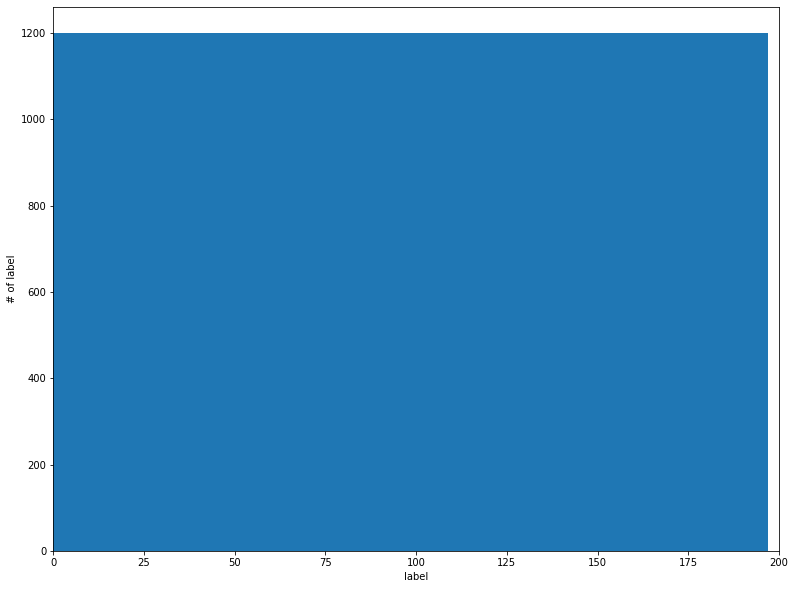

In [11]:
plt.hist(train_label_sm, bins=len(train_label_sm.unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()

In [12]:
print(train_data_sm, train_label_sm)

            V0000     V0001     V0002     V0003     V0004       V0005  \
0       30.472197  8.695875  8.703739  8.709477  8.711114  200.381358   
1       30.451815  8.635427  8.705436  8.699428  8.711520  181.601175   
2       30.464503  8.743024  8.725929  8.671431  8.743335  198.761704   
3       30.483019  8.752263  8.711617  8.776546  8.703115  169.724555   
4       30.473983  8.740589  8.692430  8.740275  8.717582  186.863251   
...           ...       ...       ...       ...       ...         ...   
237595  30.467522  8.641007  8.692360  8.693235  8.710832  182.895531   
237596  30.455637  8.707817  8.703627  8.693805  8.735976  195.339574   
237597  30.474915  8.669603  8.699656  8.700953  8.705987  177.633174   
237598  30.474853  8.728208  8.688101  8.691500  8.706933  159.945913   
237599  30.477711  8.804493  8.696023  8.700584  8.737530  207.811225   

             V0006         V0007  V0008     V0009  ...  V5111  V5112  V5113  \
0       159.282182 -5.018619e-19    0.0  0.0

# SMOTE_rob

In [33]:
# Datapreprocessing 중 SMOTE data set에 스케일링 진행 / RobuestScaling 사용
# RobustScaling은 성능이 좋지 않음 - seed 문제 가능성
train_data_sm_rob = pd.DataFrame(robustScaler.fit_transform(train_data_sm), columns=train_data_sm.columns, index = train_data_sm.index.values)

X_train_sm_rob, X_test_sm_rob, Y_train_sm_rob, Y_test_sm_rob = train_test_split(train_data_sm_rob, train_label_sm, test_size=0.2, random_state=seed)
print(X_train_sm_rob,X_test_sm_rob,Y_train_sm_rob,Y_test_sm_rob)
print(X_train_sm_rob.shape,X_test_sm_rob.shape,Y_train_sm_rob.shape,Y_test_sm_rob.shape)

'\ntrain_data_sm_rob = pd.DataFrame(robustScaler.fit_transform(train_data_sm), columns=train_data_sm.columns, index = train_data_sm.index.values)\n\nX_train_sm_rob, X_test_sm_rob, Y_train_sm_rob, Y_test_sm_rob = train_test_split(train_data_sm_rob, train_label_sm, test_size=0.2, random_state=seed)\nprint(X_train_sm_rob,X_test_sm_rob,Y_train_sm_rob,Y_test_sm_rob)\nprint(X_train_sm_rob.shape,X_test_sm_rob.shape,Y_train_sm_rob.shape,Y_test_sm_rob.shape)\n'

# SMOTE_std 

In [13]:
# Datapreprocessing 중 SMOTE data set에 스케일링 진행 / standardScaling 사용
train_data_sm_std = pd.DataFrame(stdScaling.fit_transform(train_data_sm), columns=train_data_sm.columns, index = train_data_sm.index.values)

X_train_sm_std, X_test_sm_std, Y_train_sm_std, Y_test_sm_std = train_test_split(train_data_sm_std, train_label_sm, test_size=0.2, random_state=seed)
print(X_train_sm_std,X_test_sm_std,Y_train_sm_std,Y_test_sm_std)
print(X_train_sm_std.shape,X_test_sm_std.shape,Y_train_sm_std.shape,Y_test_sm_std.shape)
print(train_data_sm_std)

            V0000     V0001     V0002     V0003     V0004     V0005     V0006  \
175117   0.083008  0.077924  0.085077  0.060118  0.028357  0.382561  0.635955   
215811   0.085664  0.046824  0.038875  0.090581  0.048727 -0.086820  1.235335   
11759    0.077016 -0.029978  0.023049  0.050396  0.030815 -0.156615  0.245633   
105578   0.083533 -0.176641 -0.268401 -0.236636 -0.191911  0.656048  1.316514   
115314 -18.003431 -0.374514 -2.187696 -1.045127  0.151905 -1.469535 -2.417920   
...           ...       ...       ...       ...       ...       ...       ...   
106071   0.085536  0.106885  0.054760  0.063703  0.087280  0.116122  0.570376   
183206   0.081033  0.121746  0.063895  0.097910  0.058263  0.640307  0.879233   
212539   0.093045 -0.688011 -0.464510 -0.486468 -0.486062 -3.768316 -4.164458   
113455   0.088009  0.070142  0.071414  0.073108  0.065152 -0.016431  0.430863   
63591    0.084858  0.028511  0.063661  0.072549  0.040357  0.376133  0.600696   

           V0007     V0008 

# Binary Columns Extract

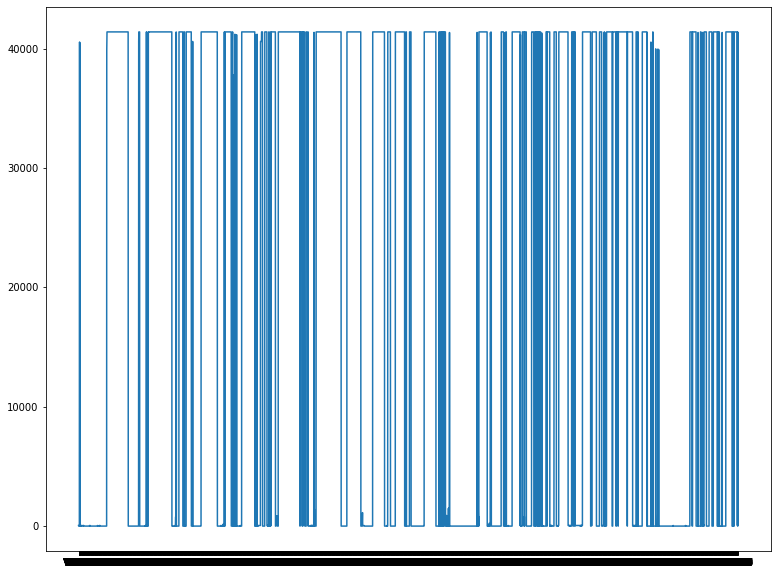

In [14]:
plt.plot(train_data.isin([0,1]).sum())

In [15]:
# binary_columns으로 추측되는 columns명 추출
binary_columns = train_data.columns[train_data.isin([0,1]).sum()>=35000].values

In [16]:
train_data_sm_std.head(5)

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
0,0.086189,0.011567,0.058476,0.068144,0.066056,0.260878,-0.501123,-0.167758,-0.134253,-0.194555,...,0.050942,0.050942,0.050942,0.050942,0.112152,-0.050942,-0.050942,-0.098870,0.189421,-0.050942
1,0.074090,-0.070026,0.060774,0.055020,0.066586,-0.113383,-0.549343,-0.167758,-0.134253,-0.194596,...,0.050942,0.050942,0.050942,0.050942,0.112152,-0.050942,-0.050942,-0.098869,0.189421,-0.050942
2,0.081622,0.075207,0.088536,0.018455,0.108149,0.228601,0.101354,-0.167758,-0.134253,-0.194577,...,0.050942,0.050942,0.050942,0.050942,0.112152,-0.050942,-0.050942,-0.098874,0.189421,-0.050942
3,0.092613,0.087678,0.069148,0.155735,0.055605,-0.350066,-0.157260,-0.167758,-0.134253,-0.194613,...,0.050942,0.050942,0.050942,0.050942,0.112152,-0.050942,-0.050942,-0.098871,0.189421,-0.050942
4,0.087249,0.071920,0.043154,0.108365,0.074505,-0.008517,-0.297083,-0.167758,-0.134253,-0.194563,...,0.050942,0.050942,0.050942,0.050942,0.112152,-0.050942,-0.050942,-0.098868,0.189421,-0.050942


In [17]:
# StandardScaing 처리 데이터 중 기존 binary_columns은 그대로 binary로 둘 수 있도록 처리
for i in binary_columns:
    train_data_sm_std[i] = train_data_sm[i]

In [18]:
train_data_sm_std.head(5)

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
0,0.086189,0.011567,0.058476,0.068144,0.066056,0.260878,-0.501123,-0.167758,0.0,-0.194555,...,1.0,1.0,1.0,1.0,0.112152,0.0,0.0,-0.098870,0.189421,0.0
1,0.074090,-0.070026,0.060774,0.055020,0.066586,-0.113383,-0.549343,-0.167758,0.0,-0.194596,...,1.0,1.0,1.0,1.0,0.112152,0.0,0.0,-0.098869,0.189421,0.0
2,0.081622,0.075207,0.088536,0.018455,0.108149,0.228601,0.101354,-0.167758,0.0,-0.194577,...,1.0,1.0,1.0,1.0,0.112152,0.0,0.0,-0.098874,0.189421,0.0
3,0.092613,0.087678,0.069148,0.155735,0.055605,-0.350066,-0.157260,-0.167758,0.0,-0.194613,...,1.0,1.0,1.0,1.0,0.112152,0.0,0.0,-0.098871,0.189421,0.0
4,0.087249,0.071920,0.043154,0.108365,0.074505,-0.008517,-0.297083,-0.167758,0.0,-0.194563,...,1.0,1.0,1.0,1.0,0.112152,0.0,0.0,-0.098868,0.189421,0.0


In [22]:
test_std

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
1012,0.114666,0.056192,0.021120,0.085131,0.053828,-0.096794,-0.258877,-0.160842,-0.100222,-0.168924,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.121723,-0.009512,0.033104,0.045430,0.019075,-0.274228,0.867373,-0.160842,-0.100222,-0.168899,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.108674,0.120699,0.026048,0.032856,0.038611,0.193965,-0.131763,-0.160842,-0.100222,-0.168913,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124633,0.159475,0.051132
1012,0.119231,0.012726,0.047575,0.049154,0.023182,0.487265,-0.251279,-0.160842,-0.100222,-0.168915,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.110610,0.020398,0.056980,0.087677,0.036254,-0.564322,-0.564507,-0.160842,-0.100222,-0.168918,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124633,0.159475,0.051132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,0.085984,0.148052,-0.000654,0.067609,0.045841,0.545565,0.530769,-0.160842,-0.100222,-0.168989,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124634,0.159475,0.051132
1037,0.105755,-0.100532,0.058149,0.053597,0.023599,0.279928,-1.000085,-0.160842,-0.100222,-0.168924,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124631,0.159475,0.051132
1037,0.115688,-0.036071,0.052631,0.045651,0.000789,0.168394,0.059114,-0.160842,-0.100222,-0.168911,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1037,0.088624,0.072788,0.048777,0.016087,0.011427,0.564415,-0.182729,-0.160842,-0.100222,-0.168957,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124635,0.159475,0.051132


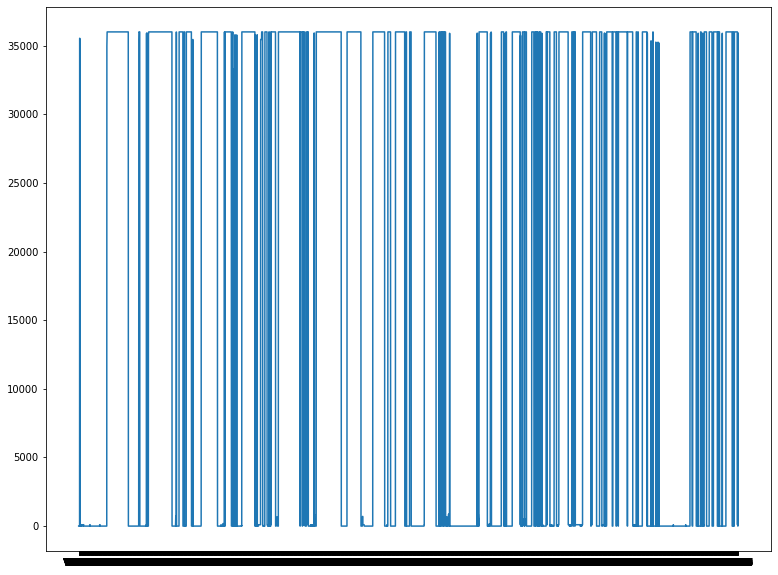

In [23]:
plt.plot(test.isin([0,1]).sum())

In [24]:
# binary_columns으로 추측되는 columns명 추출
binary_columns_test = test.columns[test.isin([0,1]).sum()>=30000].values

In [25]:
test_std.head(5)

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
1012,0.114666,0.056192,0.021120,0.085131,0.053828,-0.096794,-0.258877,-0.160842,-0.100222,-0.168924,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.121723,-0.009512,0.033104,0.045430,0.019075,-0.274228,0.867373,-0.160842,-0.100222,-0.168899,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.108674,0.120699,0.026048,0.032856,0.038611,0.193965,-0.131763,-0.160842,-0.100222,-0.168913,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124633,0.159475,0.051132
1012,0.119231,0.012726,0.047575,0.049154,0.023182,0.487265,-0.251279,-0.160842,-0.100222,-0.168915,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124632,0.159475,0.051132
1012,0.110610,0.020398,0.056980,0.087677,0.036254,-0.564322,-0.564507,-0.160842,-0.100222,-0.168918,...,0.052778,0.052778,0.052778,0.052778,0.135794,-0.052774,-0.052774,-0.124633,0.159475,0.051132


In [26]:
# StandardScaing 처리 데이터 중 기존 binary_columns은 그대로 binary로 둘 수 있도록 처리
for i in binary_columns:
    test_std[i] = test[i]

In [27]:
test_std.head(5)

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
1012,0.114666,0.056192,0.021120,0.085131,0.053828,-0.096794,-0.258877,-0.160842,0.0,-0.168924,...,1.0,1.0,1.0,1.0,0.135794,0.0,0.0,-0.124632,0.159475,0.0
1012,0.121723,-0.009512,0.033104,0.045430,0.019075,-0.274228,0.867373,-0.160842,0.0,-0.168899,...,1.0,1.0,1.0,1.0,0.135794,0.0,0.0,-0.124632,0.159475,0.0
1012,0.108674,0.120699,0.026048,0.032856,0.038611,0.193965,-0.131763,-0.160842,0.0,-0.168913,...,1.0,1.0,1.0,1.0,0.135794,0.0,0.0,-0.124633,0.159475,0.0
1012,0.119231,0.012726,0.047575,0.049154,0.023182,0.487265,-0.251279,-0.160842,0.0,-0.168915,...,1.0,1.0,1.0,1.0,0.135794,0.0,0.0,-0.124632,0.159475,0.0
1012,0.110610,0.020398,0.056980,0.087677,0.036254,-0.564322,-0.564507,-0.160842,0.0,-0.168918,...,1.0,1.0,1.0,1.0,0.135794,0.0,0.0,-0.124633,0.159475,0.0


# RandomForest 

In [63]:
model_smote_rf = RandomForestClassifier(random_state=seed, verbose=1, n_jobs=-1)
model_smote_rf.fit(train_data_sm, train_label_sm)
pred = model_smote_rf.predict_proba(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 39.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


In [65]:
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission_baseline_sm.csv', index=True) #제출 파일 만들기

In [69]:
# LeaderBoard : 17:08:09 0.8885022881 , seed = 0 
#joblib.dump(model_smote_rf, 'smote_rf_model.pkl')

['smote_rf_model.pkl']

In [13]:
model_smote_rf = joblib.load('smote_rf_model.pkl.pkl')

In [34]:
model_smote_rob_rf = RandomForestClassifier(random_state=seed, verbose=1, n_jobs=-1)
model_smote_rob_rf.fit(train_data_sm_rob, train_label_sm)
pred = model_smote_rob_rf.predict_proba(test_rob)

'\nmodel_smote_rob_rf = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)\nmodel_smote_rob_rf.fit(train_data_sm_rob, train_label_sm)\npred = model_smote_rob_rf.predict_proba(test_rob)\n'

In [35]:
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission_baseline_sm_rob.csv', index=True) #제출 파일 만들기

"\nsubmission = pd.DataFrame(data=pred)\nsubmission.index = test.index\nsubmission.index.name = 'id'\nsubmission = submission.sort_index()\nsubmission = submission.groupby('id').mean()\nsubmission.to_csv('submission_baseline_5.csv', index=True) #제출 파일 만들기\n"

In [36]:
# 2020-02-07 12:50:56	1.5974964499

In [28]:
model_smote_std_rf = RandomForestClassifier(random_state=seed, verbose=1, n_jobs=-1)
model_smote_std_rf.fit(train_data_sm_std, train_label_sm)
pred = model_smote_std_rf.predict_proba(test_std)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 47.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [29]:
pred

array([[0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [30]:
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission_baseline_sm_std_bi.csv', index=True) #제출 파일 만들기

In [31]:
submission

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
id,,,,,,,,,,,,,,,,,,,,,
828,0.0004,0.0084,0.0110,0.0178,0.0032,0.0162,0.0306,0.0006,0.0000,0.0030,...,0.0000,0.0012,0.0,0.0062,0.0012,0.0140,0.0014,0.0,0.0,0.0
829,0.0016,0.0044,0.0082,0.0240,0.0078,0.0158,0.0220,0.0044,0.0000,0.0012,...,0.0000,0.0002,0.0,0.0044,0.0004,0.0076,0.0006,0.0,0.0,0.0
830,0.0002,0.0000,0.0000,0.0034,0.0024,0.0174,0.0238,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0114,0.0038,0.0,0.0,0.0
831,0.0000,0.0130,0.0000,0.0106,0.0564,0.0398,0.0112,0.0990,0.0000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0000,0.0010,0.0000,0.0,0.0,0.0
832,0.0000,0.0004,0.0096,0.0070,0.0140,0.0148,0.0048,0.0024,0.0002,0.0000,...,0.0000,0.0000,0.0,0.0014,0.0000,0.0080,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,0.0016,0.0106,0.0162,0.0348,0.0050,0.0282,0.0386,0.0022,0.0000,0.0004,...,0.0000,0.0014,0.0,0.0062,0.0052,0.0186,0.0034,0.0,0.0,0.0
1544,0.0010,0.0050,0.0116,0.0246,0.0038,0.0180,0.0182,0.0012,0.0000,0.0022,...,0.2894,0.0002,0.0,0.0076,0.0006,0.0080,0.0054,0.0,0.0,0.0
1545,0.0016,0.0046,0.0188,0.0446,0.0108,0.0180,0.0382,0.0106,0.0000,0.0018,...,0.0000,0.0000,0.0,0.0000,0.0018,0.0218,0.0042,0.0,0.0,0.0


# lightGBM

In [ ]:
model = lgb.LGBMClassifier()
X_train_sm_std.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
lgb_params = {
        'objective':'multiclass',
        'boosting_type':'gbdt' #gradient boosting decision tree
        'metric':'multi_logloss',
        'num_class':train_label.unique.shape[1],
        'learning_rate':0.02,
        'seed': seed,
        'n_jobs': -1
    }
model.fit(X_train_sm_std,Y_train_sm_std)

In [ ]:
expected_y  = Y_test_sm_rob
predicted_y = model.predict(X_test_sm_rob)
print(); print('LightGBM: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

In [ ]:
model3 = lgb.LGBMClassifier(learning_rate=0.02, boosting_type = 'gbdt', metric = 'multi_logloss', seed = 777, n_jobs = -1)
evals = [(r_X_test, r_Y_test)]
model3.fit(r_X_train, r_Y_train, eval_set=evals, eval_metric='logloss', early_stopping_rounds=20, verbose=True)

# DNN Model 

In [20]:
encoder = LabelEncoder()
encoder.fit(train_label)
encoded_Y = encoder.transform(train_label)
dummy_y = np_utils.to_categorical(encoded_Y)

In [21]:
def make_DNN():
    model = Sequential([
    Dense(1024, input_dim=5121, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(198, activation='softmax')])
    return model

In [22]:
model_DNN = make_DNN()
model_DNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              5244928   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 198)               50886     
Total params: 5,951,942
Trainable params: 5,951,942
Non-trainable params: 0
_________________________________________________________________


In [23]:
keras.initializers.he_normal()
model_DNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=30)
hist = model_DNN.fit(train_data_rob, dummy_y, validation_split=0.3, batch_size=200, epochs=1000, callbacks=[early_stopping])

Train on 28979 samples, validate on 12421 samples
Epoch 1/1000
28979/28979 [==============================] - 26s 901us/step - loss: 629282083903617920.0000 - accuracy: 0.4976 - val_loss: 27770008832061596.0000 - val_accuracy: 0.4814
Epoch 2/1000
28979/28979 [==============================] - 29s 984us/step - loss: 78684071555445936.0000 - accuracy: 0.5837 - val_loss: 13788125591107526.0000 - val_accuracy: 0.5349
Epoch 3/1000
28979/28979 [==============================] - 28s 952us/step - loss: 34543881195856116.0000 - accuracy: 0.6101 - val_loss: 6214360503221876.0000 - val_accuracy: 0.5472
Epoch 4/1000
28979/28979 [==============================] - 27s 938us/step - loss: 12360413067839272.0000 - accuracy: 0.6251 - val_loss: 2911016473873776.0000 - val_accuracy: 0.5363
Epoch 5/1000
28979/28979 [==============================] - 26s 898us/step - loss: 15933269910294396.0000 - accuracy: 0.6331 - val_loss: 1233628436722654.0000 - val_accuracy: 0.5409
Epoch 6/1000
28979/28979 [===========

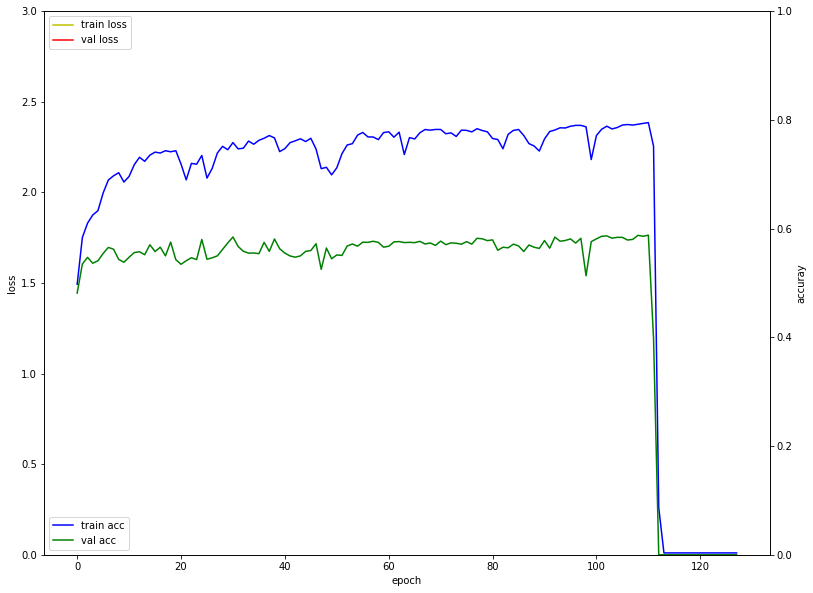

In [24]:

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


# CNN

In [ ]:
def make_DNN():
    model = Sequential([
    Dense(1024, input_dim=5121, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(198, activation='softmax')])
    return model

In [ ]:
model_DNN = make_DNN()
model_DNN.summary()

In [ ]:
keras.initializers.he_normal()
model_DNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=30)
hist = model_DNN.fit(train_data_rob, dummy_y, validation_split=0.3, batch_size=200, epochs=1000, callbacks=[early_stopping])